<h1 style="text-align: center;">CM3070 Final Project</h2>

<h2 style="text-align: center;">Preliminary report: Prototyping a workflow</h3>

<h3>Fake News Detection using NLP and ML Techniques</h3>

#### Set up of the libraries to perform the linguistic predictors statistical analysis.

In [3]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import textstat
from textblob import TextBlob
import statsmodels.formula.api as smf

# Set the path to the LIAR training dataset folder and files, all of the type TAB sepparated values
dataset_path = "liar_dataset/train.tsv"

# Load the datasets into a Pandas DataFrame
tr_set = pd.read_csv(dataset_path, sep='\t', header=None)

# Assign column names to the DataFrames following README text file info
tr_set.columns = ["ID", "Label", "Statement", "Subject", "Speaker", "Speaker's Job Title",
              "State Info", "Party Affiliation", "Count 1", "Count 2", "Count 3", "Count 4", "Count 5", "Statement Context"]

# Display the first few rows of the dataset for inspection
tr_set.head(10)

,ID,Label,Statement,Subject,Speaker,Speaker's Job Title,State Info,Party Affiliation,Count 1,Count 2,Count 3,Count 4,Count 5,Statement Context
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN
5,12465.json,true,The Chicago Bears have had more starting quart...,education,robin-vos,Wisconsin Assembly speaker,Wisconsin,republican,0.0,3.0,2.0,5.0,1.0,a an online opinion-piece
6,2342.json,barely-true,Jim Dunnam has not lived in the district he re...,candidates-biography,republican-party-texas,NaN,Texas,republican,3.0,1.0,1.0,3.0,1.0,a press release.
7,153.json,half-true,I'm the only person on this stage who has work...,ethics,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,"a Democratic debate in Philadelphia, Pa."
8,5602.json,half-true,"However, it took $19.5 million in Oregon Lotte...",jobs,oregon-lottery,NaN,NaN,organization,0.0,0.0,1.0,0.0,1.0,a website
9,9741.json,mostly-true,Says GOP primary opponents Glenn Grothman and ...,"energy,message-machine-2014,voting-record",duey-stroebel,State representative,Wisconsin,republican,0.0,0.0,0.0,1.0,0.0,an online video


In [4]:
# Calculate the total count of rows in each dataset and display the information
tr_set_count = len(tr_set)

print("Total count of rows in the LIAR training dataset: {}".format(tr_set_count))

Total count of rows in the LIAR training dataset: 10240


#### Data Preprocessing:

- Dropping non used columns. I am using only the **Label** and **Statement** columns for this prototype. 
- Creation of a new **Outcome** *binary variable* from **Label** column (**0**: TRUE News, **1**: False News) using **Truth-O-Meter ratings**: [https://www.politifact.com/article/2018/feb/12/principles-truth-o-meter-politifacts-methodology-i/#Truth-O-Meter%20ratings]
- Lowering case and punctuation cleaning.
- Tokenization was not performed in this project as the models being studied don't rely on them.

In [5]:
# Remove unnecessary columns
tr_set = tr_set[["Label", "Statement"]]

# Create the Outcome binary variable from Label column (0: TRUE News, 1: False News) using Truth-O-Meter ratings
tr_set["Outcome"] = tr_set["Label"].apply(lambda x: 0 if x == "TRUE" or x == "mostly-true" else 1)

# Remove any missing or empty rows
tr_set.dropna(inplace=True)

# Convert the text to lowercase
tr_set["Statement"] = tr_set["Statement"].str.lower()

# Cleaning: removing non-words, punctuation
tr_set["Statement"] = tr_set["Statement"].str.replace('[^\w\s]', '', regex=True)

# Tokenization: splitting into individual words
# tr_set["Statement"] = tr_set["Statement"].str.split()

# Display the preprocessed dataset
tr_set.head(10)

,Label,Statement,Outcome
0,false,says the annies list political group supports ...,1
1,half-true,when did the decline of coal start it started ...,1
2,mostly-true,hillary clinton agrees with john mccain by vot...,0
3,false,health care reform legislation is likely to ma...,1
4,half-true,the economic turnaround started at the end of ...,1
5,true,the chicago bears have had more starting quart...,1
6,barely-true,jim dunnam has not lived in the district he re...,1
7,half-true,im the only person on this stage who has worke...,1
8,half-true,however it took 195 million in oregon lottery ...,1
9,mostly-true,says gop primary opponents glenn grothman and ...,0


#### Count of False News and True News in the dataset after using the using Truth-O-Meter ratings

In [6]:
print("\n1 means <False News>")
print("\n0 means <True News>\n")
print(tr_set.value_counts("Outcome"))



1 means <False News>

0 means <True News>

Outcome
1    8278
0    1962
Name: count, dtype: int64


This project goals estate to explore first **classification predictors** using *pure* lexical and linguistic approachs, informed by the research literature (Fernández-López & Perea, 2020; Kolinsky et al., 2021).

The first step is the calculation of two *suitable* **predictors**:

- Flesch-Kincaid Grade Level readability score. It is a U.S. school grade level. A score of 8.0 means that an eighth grader can understand the document. For most documents, it is expected a score of approximately 7.0 to 8.0. [Microsoft Support page with Office Word Instructions](https://support.microsoft.com/en-au/office/get-your-document-s-readability-and-level-statistics-85b4969e-e80a-4777-8dd3-f7fc3c8b3fd2)
- Sentiment Analysis polarity score. A lexicon-based approach. It requires a pre-defined dictionary classifying negative and positive words. The final score is given by some aggregate function run over the individual words score of the text. [Towards DataScience Blog explanation](https://towardsdatascience.com/my-absolute-go-to-for-sentiment-analysis-textblob-3ac3a11d524)


#### First automatic calculation of predictors: Readability Score and Sentiment Polarity

In [7]:

# Calculate Flesch-Kincaid Grade Level score and add as a new column
tr_set["Readability_Score"] = tr_set["Statement"].apply(textstat.flesch_kincaid_grade)

# Sentiment Analysis using TextBlob polarity score, range [-1, 1], from negative sentiment to positive sentiment
tr_set["Sentiment_Polarity"] = tr_set["Statement"].apply(lambda x: TextBlob(x).sentiment.polarity)

# Display the preprocessed dataset
tr_set.head()

,Label,Statement,Outcome,Readability_Score,Sentiment_Polarity
0,false,says the annies list political group supports ...,1,7.6,0.0
1,half-true,when did the decline of coal start it started ...,1,11.5,0.1
2,mostly-true,hillary clinton agrees with john mccain by vot...,0,7.2,0.0
3,false,health care reform legislation is likely to ma...,1,8.0,0.2
4,half-true,the economic turnaround started at the end of ...,1,4.8,0.2


In order to explore systematically the *predictive value* of the two selected predictors (**Readability score** and **Sentiment polarity**), I will perform a series of **logistic regressions** using *statmodels* package.
First, two models including *each of the predictors* individually, then a third model including *both predictors* and finally a fourth model including *both predictors and the interaction term*. All models will include the intercept (with a value of **1.0** added *automatically* by statmodels formula api).

The **pseudo R-square** value will be used to *assess model performance* (i.e. the *highest pseudo r-square* indicating a *better model fit*). The **LLR p-value** will be used to assess whether the *model as a whole is useful* (i.e. whether the model is better at predicting the values of the outcome variable than a model with *no predictor variables*).
After selecting the *best fit* model (the significant model with *highest pseudo R-square value*), I will assess the *level of significance* of the predictor(s) using the **P>|z|** value. I will also examine the *direction of the predictive effect* looking at the *coeficient value*.
If the selected predictors do not result in a *useful model*, I will follow the *same analysis procedure* described above with *different predictors*.

#### Perform Logistic regression for a classification problem

#### Creation of 4 different models:

#### 1) Perform the logistic regression using Readability Score predictor

In [8]:

log_reg_readscr_predic = smf.logit("Outcome ~ Readability_Score", data=tr_set).fit()

# Display the logistic regression summary
print("\nOutcome ~ Readability_Score")
print(log_reg_readscr_predic.summary())

Optimization terminated successfully.
         Current function value: 0.488505
         Iterations 5

Outcome ~ Readability_Score
                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                10240
Model:                          Logit   Df Residuals:                    10238
Method:                           MLE   Df Model:                            1
Date:                Sun, 16 Jun 2024   Pseudo R-squ.:               6.441e-05
Time:                        22:15:41   Log-Likelihood:                -5002.3
converged:                       True   LL-Null:                       -5002.6
Covariance Type:            nonrobust   LLR p-value:                    0.4221
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             1.4810      0.057     26.085      0.000    

#### 2) Perform the logistic regression using Sentiment Polarity predictor

In [9]:

log_reg_sentpol_predic = smf.logit("Outcome ~ Sentiment_Polarity", data=tr_set).fit()

# Display the logistic regression summary
print("\nOutcome ~ Sentiment_Polarity")
print(log_reg_sentpol_predic.summary())

Optimization terminated successfully.
         Current function value: 0.488537
         Iterations 5

Outcome ~ Sentiment_Polarity
                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                10240
Model:                          Logit   Df Residuals:                    10238
Method:                           MLE   Df Model:                            1
Date:                Sun, 16 Jun 2024   Pseudo R-squ.:               2.039e-07
Time:                        22:16:01   Log-Likelihood:                -5002.6
converged:                       True   LL-Null:                       -5002.6
Covariance Type:            nonrobust   LLR p-value:                    0.9640
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              1.4394      0.026     55.764      0.000

#### 3) Perform the logistic regression using the two predictors

In [10]:

log_reg_2predic = smf.logit("Outcome ~ Readability_Score + Sentiment_Polarity", data=tr_set).fit()

# Display the logistic regression summary
print("\nOutcome ~ Readability_Score + Sentiment_Polarity")
print(log_reg_2predic.summary())

Optimization terminated successfully.
         Current function value: 0.488505
         Iterations 5

Outcome ~ Readability_Score + Sentiment_Polarity
                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                10240
Model:                          Logit   Df Residuals:                    10237
Method:                           MLE   Df Model:                            2
Date:                Sun, 16 Jun 2024   Pseudo R-squ.:               6.464e-05
Time:                        22:16:08   Log-Likelihood:                -5002.3
converged:                       True   LL-Null:                       -5002.6
Covariance Type:            nonrobust   LLR p-value:                    0.7237
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              1.4807      0.057  

#### 4) Perform the logistic regression using the interaction between the two predictors

In [11]:

log_reg_interacc_predic = smf.logit("Outcome ~ Readability_Score + Sentiment_Polarity + Readability_Score * Sentiment_Polarity", data=tr_set).fit()

# Display the logistic regression summary
print("\nOutcome ~ Readability_Score + Sentiment_Polarity + Readability_Score * Sentiment_Polarity")
print(log_reg_interacc_predic.summary())

Optimization terminated successfully.
         Current function value: 0.488455
         Iterations 5

Outcome ~ Readability_Score + Sentiment_Polarity + Readability_Score * Sentiment_Polarity
                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                10240
Model:                          Logit   Df Residuals:                    10236
Method:                           MLE   Df Model:                            3
Date:                Sun, 16 Jun 2024   Pseudo R-squ.:               0.0001675
Time:                        22:16:44   Log-Likelihood:                -5001.8
converged:                       True   LL-Null:                       -5002.6
Covariance Type:            nonrobust   LLR p-value:                    0.6424
                                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------

#### Results:

**None** of the models fitted the data significantly better than a model with no predictors (i.e. all **LLR p-values** were close to **1** and hence far from any acceptable significance threshold). Accordingly, all **pseudo R-square** values were close to **0** and none of the predictors was significant (*all* **P>|z|** were higher than **0.31**). Therefore I will select a *different set of predictors* and run the above analysis using them.

#### Subjectivity score as predictor

The rationale of using subjectivity follows from the failure of the polarity predictor. The intensity of the emotion coumpounded, negative or positive, is a candidate for a model better fit.

The next section explore the logistic regression of the subjectivity predictor alone, and together with the polarity predictor. The interaction of the two predictors in the final regression table can be seen as an aproximation of a emotion intensity predictor.

In [12]:
# Sentiment Analysis using TextBlob subjectivity score, range [0, 1], from low subjectivity to high subjectivity
tr_set["Sentiment_Subjetivity"] = tr_set["Statement"].apply(lambda x: TextBlob(x).sentiment.subjectivity)

# Display the preprocessed dataset
tr_set.head()

,Label,Statement,Outcome,Readability_Score,Sentiment_Polarity,Sentiment_Subjetivity
0,false,says the annies list political group supports ...,1,7.6,0.0,0.1
1,half-true,when did the decline of coal start it started ...,1,11.5,0.1,0.4
2,mostly-true,hillary clinton agrees with john mccain by vot...,0,7.2,0.0,0.0
3,false,health care reform legislation is likely to ma...,1,8.0,0.2,0.9
4,half-true,the economic turnaround started at the end of ...,1,4.8,0.2,0.2


#### 5) Perform the logistic regression using Sentiment Subjetivity predictor

In [13]:

log_reg_sentsubj_predic = smf.logit("Outcome ~ Sentiment_Subjetivity", data=tr_set).fit()

# Display the logistic regression summary
print("\nOutcome ~ Sentiment_Subjetivity")
print(log_reg_sentsubj_predic.summary())

Optimization terminated successfully.
         Current function value: 0.488023
         Iterations 5

Outcome ~ Sentiment_Subjetivity
                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                10240
Model:                          Logit   Df Residuals:                    10238
Method:                           MLE   Df Model:                            1
Date:                Sun, 16 Jun 2024   Pseudo R-squ.:                0.001051
Time:                        22:17:37   Log-Likelihood:                -4997.4
converged:                       True   LL-Null:                       -5002.6
Covariance Type:            nonrobust   LLR p-value:                  0.001181
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 1.5200      0.036     42.67

#### Repetition of the Sentiment Polarity predictor logistic regression, to allow comparison

In [14]:
# 2) Perform the logistic regression using Sentiment Polarity predictor
log_reg_sentpol_predic = smf.logit("Outcome ~ Sentiment_Polarity", data=tr_set).fit()

# Display the logistic regression summary
print("\nOutcome ~ Sentiment_Polarity")
print(log_reg_sentpol_predic.summary())

Optimization terminated successfully.
         Current function value: 0.488537
         Iterations 5

Outcome ~ Sentiment_Polarity
                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                10240
Model:                          Logit   Df Residuals:                    10238
Method:                           MLE   Df Model:                            1
Date:                Sun, 16 Jun 2024   Pseudo R-squ.:               2.039e-07
Time:                        22:17:43   Log-Likelihood:                -5002.6
converged:                       True   LL-Null:                       -5002.6
Covariance Type:            nonrobust   LLR p-value:                    0.9640
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              1.4394      0.026     55.764      0.000

#### 6) Perform the logistic regression using the two Sentiment values as predictors

In [15]:

log_reg_2sent_interacc_predic = smf.logit("Outcome ~ Sentiment_Polarity + Sentiment_Subjetivity", data=tr_set).fit()

# Display the logistic regression summary
print("\nOutcome ~ Sentiment_Polarity + Sentiment_Subjetivity")
print(log_reg_2sent_interacc_predic.summary())

Optimization terminated successfully.
         Current function value: 0.487994
         Iterations 5

Outcome ~ Sentiment_Polarity + Sentiment_Subjetivity
                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                10240
Model:                          Logit   Df Residuals:                    10237
Method:                           MLE   Df Model:                            2
Date:                Sun, 16 Jun 2024   Pseudo R-squ.:                0.001112
Time:                        22:17:55   Log-Likelihood:                -4997.1
converged:                       True   LL-Null:                       -5002.6
Covariance Type:            nonrobust   LLR p-value:                  0.003832
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 1.5195

#### 7) Perform the logistic regression using the interaction between the two Sentiment values as predictors

In [16]:

log_reg_2sent_interacc_predic = smf.logit("Outcome ~ Sentiment_Polarity + Sentiment_Subjetivity + Sentiment_Polarity * Sentiment_Subjetivity", data=tr_set).fit()

# Display the logistic regression summary
print("\nOutcome ~ Sentiment_Polarity + Sentiment_Subjetivity + Sentiment_Polarity * Sentiment_Subjetivity")
print(log_reg_2sent_interacc_predic.summary())

Optimization terminated successfully.
         Current function value: 0.487828
         Iterations 5

Outcome ~ Sentiment_Polarity + Sentiment_Subjetivity + Sentiment_Polarity * Sentiment_Subjetivity
                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                10240
Model:                          Logit   Df Residuals:                    10236
Method:                           MLE   Df Model:                            3
Date:                Sun, 16 Jun 2024   Pseudo R-squ.:                0.001450
Time:                        22:18:01   Log-Likelihood:                -4995.4
converged:                       True   LL-Null:                       -5002.6
Covariance Type:            nonrobust   LLR p-value:                  0.002288
                                               coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------

#### Results: 

The sentiment subjectivity, both emotional measures and the interaction resulted in significant models (**P>|z|’s** < **0.004**). However, the **pseudo R-square** values were extremely low (e.g. **0.001** for the best fitted model), indicating an extremely low percentage of explained variance. Therefore, **I considered this approach not good enough** for the purpose of classifying accurately false news from true news.

### Using supervised learning techniques from Machine Learning.

A *second approach* is to estract the right features to create a better fitted model. Instead of pure linguistics criteria, we use pure machine learning techniques for this task.

The approach is to find a model that is suitable enough to serve as a *baseline of performance*. Going further, we try to *improve over that performance* using different models.

The *baseline performance benchmark* criteria performance benchmark criteria is:

- the model should be better than a random chance approach, which can perform well if the dataset is balanced and if benchmarking is performed using Accuracy.

- We use Recall as the benchmark for this approach and not Accuracy or Precision.

The rationale for the use of Recall is:

- False news or misguiding are likely more damaging than lack of information. Lack of information will affect each person’s decisions differently as they would either use their previous knowledge or actively seek information. However, disinformation can affect decisions consistently for most people as is less likely to be fact-checked in a consistent manner by the receiver. Hence, I will use a benchmark that shows the ratio of correctly classifying False News among all the real False News provided in the testing dataset.

We have not considered precision the best benchmark here, but it would not be inadequate because the consequences of selecting a model that performs more poorly classifying real True News and rejecting them as false are less damaging.  
Accuracy can produce high benchmark scores for unsuitable models that create mostly false positives when the data is mostly true positives. A peak of information activity triggered by an event (different from balanced datasets at a different moment can show an apparent high-performance model if fitted specifically for such peaks and can fail in classifying correctly when the datasets are balanced differently.

The published literature (W. Y. Wang, 2017) cites accuracy as the benchmark. We add accuracy for comparisons with the literature and the recall for comparisons among the models being tested in the project.


Models under scrutiny are:

1 **Random Forest**. (our baseline)

2 **Naive Bayes**.

3 **Logistic Regression**.

4 **Gradient Boosting Classifier**.

We use *sklearn* python library for the implementation of these models and their performance benchmark.

All of them are *supervised learning* techniques that needs *number vectors* as *feature* inputs. We convert the sentences in the "Statement" column into a number vector using *TfidfVectoriser* from *sklearn*.

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix

# Create an instance of TfidfVectorizer
vectorizer = TfidfVectorizer(analyzer='word')

# Convert the statements into a numeric vector representation and...
# ...convert the vector representation into a new Pandas DataFrame
tr_set_vec = vectorizer.fit_transform(tr_set["Statement"])
tr_set_stat_vec = pd.DataFrame(tr_set_vec.toarray(), columns=vectorizer.get_feature_names_out())

# Concatenate the outcome variable and the statement vectors for the split later
tr_set_stat_vec_out = pd.concat([tr_set["Outcome"], tr_set_stat_vec], axis=1)

# Display the DataFrame with the outcome variable and statement vectors
tr_set_stat_vec_out.head(10)

,Outcome,005,01,02,025,03,04,047,05,06,...,zip,zippo,zombie,zombies,zone,zones,zoning,zoo,zuckerberg,zuckerbergs
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Sanity check of the statement vector size:**

In [18]:
if tr_set_count == len(tr_set_stat_vec_out): print ("TRUE: {}".format(len(tr_set_stat_vec_out)))

TRUE: 10240


The dataset needs to be split in two portions randomly. One part, the 80% of the statements and associated outcomes, will train the ML algorithms. The second part, 20% of the statements and associated outcomes, will be used to test and benchamrk the fitness of the model.

In [19]:
# X is the dataset of features only
X = tr_set_stat_vec_out.drop("Outcome", axis=1)

# y is the dataset of the label(s) to be learnt
y = tr_set["Outcome"]

# Split the data in training [80%] and test [20%] datasets, random_state guarantess repeteable random splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X.head()

,005,01,02,025,03,04,047,05,06,07,...,zip,zippo,zombie,zombies,zone,zones,zoning,zoo,zuckerberg,zuckerbergs
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Training a Random Forest model and benchmarking it.

In [20]:
# Train the Random Forest model using the statement vector matrix and the outcome label training sets
rf_clfr = RandomForestClassifier(n_jobs=-1)
rf_model = rf_clfr.fit(X_train, y_train)

# Test the model against the testing set
rf_predict = rf_model.predict(X_test)

# Performance scores
print("\nAccuracy Score: {}".format(accuracy_score(y_test, rf_predict)))

print("\nRecall Score: {}".format(recall_score(y_test, rf_predict)))


Accuracy Score: 0.814453125

Recall Score: 0.9993997599039616



True means <False News>


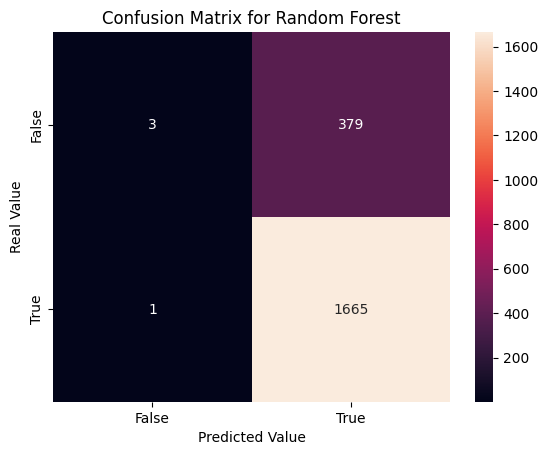

In [21]:
import seaborn as sns

cm_rf = confusion_matrix(y_test, rf_predict)
class_label = ["False", "True"]
cm_rf_set = pd.DataFrame(cm_rf, index=class_label,columns=class_label)
sns.heatmap(cm_rf_set, annot=True, fmt='d')
print("\nTrue means <False News>")
plt.title("Confusion Matrix for Random Forest")
plt.xlabel("Predicted Value")
plt.ylabel("Real Value")
plt.show()

### Training a Naive Bayes model and benchmarking it.

In [22]:
from sklearn.naive_bayes import MultinomialNB, ComplementNB

# Train the Naive Bayes model using the statement vector matrix and the outcome label traning sets
naive_bayes = ComplementNB()
nb_model = naive_bayes.fit(X_train, y_train)

# Test the model against the testing set
nb_predict = nb_model.predict(X_test)

# Performance scores
print("\nAccuracy Score: {}".format(accuracy_score(y_test, nb_predict)))

print("\nRecall Score: {}".format(recall_score(y_test, nb_predict)))


Accuracy Score: 0.77587890625

Recall Score: 0.9423769507803121



True means <False News>


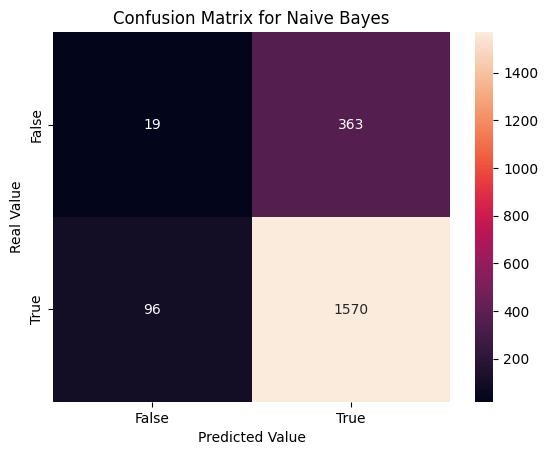

In [23]:
cm_nb = confusion_matrix(y_test, nb_predict)
class_label = ["False", "True"]
cm_nb_set = pd.DataFrame(cm_nb, index=class_label,columns=class_label)
sns.heatmap(cm_nb_set, annot=True, fmt='d')
print("\nTrue means <False News>")
plt.title("Confusion Matrix for Naive Bayes")
plt.xlabel("Predicted Value")
plt.ylabel("Real Value")
plt.show()

### Training a Logistic Regression model and benchmarking it.

In [24]:
from sklearn.linear_model import LogisticRegression

# Train the Logistic Regression model using the statement vector matrix and the outcome label traning sets
logistic_regression = LogisticRegression()
lr_model = logistic_regression.fit(X_train, y_train)

# Test the model against the testing set
lr_predict = lr_model.predict(X_test)

# Performance scores
print("\nAccuracy Score: {}".format(accuracy_score(y_test, lr_predict)))

print("\nRecall Score: {}".format(recall_score(y_test, lr_predict)))


Accuracy Score: 0.81298828125

Recall Score: 0.9981992797118847



True means <False News>


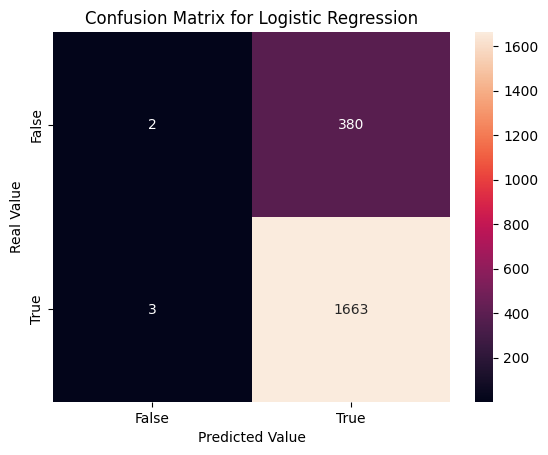

In [25]:
cm_lr = confusion_matrix(y_test, lr_predict)
class_label = ["False", "True"]
cm_lr_set = pd.DataFrame(cm_lr, index=class_label,columns=class_label)
sns.heatmap(cm_lr_set, annot=True, fmt='d')
print("\nTrue means <False News>")
plt.title("Confusion Matrix for Logistic Regression")
plt.xlabel("Predicted Value")
plt.ylabel("Real Value")
plt.show()

### Training a Gradient Boosting Classifier model and benchmarking it.

In [26]:
from sklearn.ensemble import GradientBoostingClassifier

# Train the Gradient Boosting Classifier model
gradient_boosting = GradientBoostingClassifier()
gb_model = gradient_boosting.fit(X_train, y_train)

# Make predictions on the testing set
gb_predict = gb_model.predict(X_test)

# Performance scores
print("\nAccuracy Score: {}".format(accuracy_score(y_test, gb_predict)))

print("\nRecall Score: {}".format(recall_score(y_test, gb_predict)))


Accuracy Score: 0.81298828125

Recall Score: 0.9993997599039616



True means <False News>


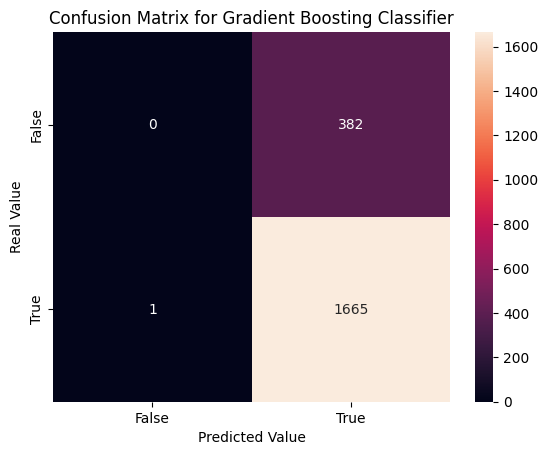

In [27]:
cm_gb = confusion_matrix(y_test, gb_predict)
class_label = ["False", "True"]
cm_gb_set = pd.DataFrame(cm_gb, index=class_label,columns=class_label)
sns.heatmap(cm_gb_set, annot=True, fmt='d')
print("\nTrue means <False News>")
plt.title("Confusion Matrix for Gradient Boosting Classifier")
plt.xlabel("Predicted Value")
plt.ylabel("Real Value")
plt.show()